In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable

from regressCNN import RegressionPCA

from data_processing import *

/home/dgist/miniconda3/envs/HSE/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cuda_available = torch.cuda.is_available()
print('cuda available:', cuda_available)

device = torch.device('cuda:0' if cuda_available else 'cpu')

cuda available: True


In [4]:
def repeat_data(x):
    row, col = x.shape
    data = np.zeros([row, col+2])
    data[:, 0] = x[:, -1]
    data[:, 1:-1] = x
    data[:, -1] = x[:, 0]
    return data

In [5]:
class HSEDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.frontal = []
        self.lateral = []
        self.shape = []

        self.transform = transform

        for dir in tqdm(os.listdir(data_path), desc='loading data'):
            path = os.path.join(data_path, dir)
            f = np.load(os.path.join(path, 'frontal.npy'))
            l = np.load(os.path.join(path, 'lateral.npy'))
            s = np.load(os.path.join(path, 'shape.npy'))

            self.frontal.append(f)
            self.lateral.append(l)
            self.shape.append(s)

    def __getitem__(self, i):
        f = self.frontal[i]
        l = self.lateral[i]
        s = self.shape[i]

        f = repeat_data(f.transpose())
        l = repeat_data(l.transpose())
        return f, l, s

    def __len__(self):
        return len(self.frontal)

In [6]:
batch_size = 32
learning_rate = 1e-5
training_epoch = 200

In [7]:
train_dataset = HSEDataset('../../dataset-generation/datasets/HSE/sample_648/train/')
test_dataset = HSEDataset('../../dataset-generation/datasets/HSE/sample_648/test/')

train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

print('train dataloader len:', len(train_data_loader))

loading data: 100%|██████████| 886/886 [00:01<00:00, 856.61it/s]

train dataloader len: 250


In [8]:
model = RegressionPCA(22).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

epoch:1  TrainLoss:188.538616
epoch:2  TrainLoss:124.087789
epoch:3  TrainLoss:105.456654
epoch:4  TrainLoss:94.753529
epoch:5  TrainLoss:86.211675
epoch:6  TrainLoss:79.163197
epoch:7  TrainLoss:72.703328
epoch:8  TrainLoss:70.684936
epoch:9  TrainLoss:66.815107
epoch:10  TrainLoss:62.956481
epoch:11  TrainLoss:62.783869
epoch:12  TrainLoss:60.239983
epoch:13  TrainLoss:58.503008
epoch:14  TrainLoss:57.215527
epoch:15  TrainLoss:56.246708
epoch:16  TrainLoss:56.086913
epoch:17  TrainLoss:57.600483
epoch:18  TrainLoss:54.937889
epoch:19  TrainLoss:55.159248
epoch:20  TrainLoss:54.485261
epoch:21  TrainLoss:51.161692
epoch:22  TrainLoss:51.364294
epoch:23  TrainLoss:50.685374
epoch:24  TrainLoss:49.577774
epoch:25  TrainLoss:48.956473
epoch:26  TrainLoss:48.958690
epoch:27  TrainLoss:48.459263
epoch:28  TrainLoss:47.873331
epoch:29  TrainLoss:46.935978
epoch:30  TrainLoss:46.712885
epoch:31  TrainLoss:46.187755
epoch:32  TrainLoss:46.526921
epoch:33  TrainLoss:46.614484
epoch:34  TrainL

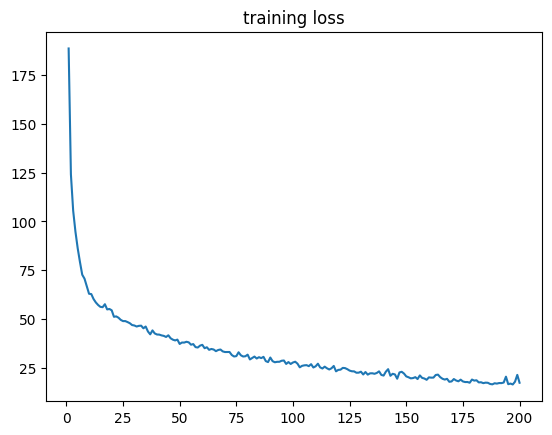

In [9]:
gender='male'

fig_loss_train = []
fig_epoch = []
for epoch in range(1, training_epoch+1):
    loss_n = 0
    for i, data_temp in enumerate(train_data_loader):
        # read data from data_loader, get 32 data each time
        front_e_ith, side_e_ith, shape_ith = data_temp
        front_e_ith, side_e_ith, shape_ith = \
            front_e_ith.to(device, dtype = torch.float), \
                side_e_ith.to(device, dtype = torch.float), \
                    shape_ith.to(device, dtype = torch.float)
        # feed data and forward pass
        outputs = model(front_e_ith, side_e_ith)
        #********************************************************************************************
        loss = criterion(outputs, shape_ith.float())
        #print(loss.item())
        #temp_e = shape_error(outputs, shape_ith.float())
        #print(temp_e)
        #loss_n += temp_e
        loss_n += loss.item()
        #********************************************************************************************
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # if epoch%5 == 0:
    #     print('epoch:{}  TrainLoss:{:.6f}'.format(epoch, loss_n))
    #     fig_loss_train = fig_loss_train + [loss_n]
    #     fig_epoch = fig_epoch + [epoch]
    #     torch.save(model.state_dict(), './model/model_{}_{}.ckpt'.format(gender, epoch))
    print('epoch:{}  TrainLoss:{:.6f}'.format(epoch, loss_n))
    fig_loss_train = fig_loss_train + [loss_n]
    fig_epoch = fig_epoch + [epoch]
    if epoch%10 == 0:
        torch.save(model.state_dict(), './model/model_{}_{}.ckpt'.format(gender, epoch))

# np.save('./data/output/{}_fig_loss_train.npy'.format(gender), np.array(fig_loss_train))

plt.plot(fig_epoch, fig_loss_train)
plt.title('training loss')
plt.show()

In [16]:
model_name = './model/model_male_200.ckpt'
infer_model = RegressionPCA(22).to(device)
infer_model.load_state_dict(torch.load(model_name))
infer_model.eval()

with torch.no_grad():
    for i, data_temp in enumerate(test_data_loader):
        # read data from data_loader, get 32 data each time
        front_e_ith, side_e_ith, shape_ith = data_temp
        front_e_ith, side_e_ith, shape_ith = \
            front_e_ith.to(device, dtype = torch.float), \
                side_e_ith.to(device, dtype = torch.float), \
                    shape_ith.to(device, dtype = torch.float)
        # feed data and forward pass
        outputs = infer_model(front_e_ith, side_e_ith)
        #********************************************************************************************
        loss = criterion(outputs, shape_ith.float())
        #print(loss.item())
        #temp_e = shape_error(outputs, shape_ith.float())
        #print(temp_e)
        #loss_n += temp_e
        loss_n += loss.item()
        #********************************************************************************************
        # backward and optimize

print(loss_n / len(test_data_loader))

2.4836557617943202
